<a href="https://colab.research.google.com/github/Nov05/DS-Unit-2-Applied-Modeling/blob/master/module1-log-linear-regression/log_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# modified by nov05 on 2019-07-22
# Week 8 Day 1
# DS-Unit-2-Applied-Modeling  
# module1-log-linear-regression/

Instruction Notebook  
https://colab.research.google.com/drive/1zpRTgVoTT2J8vkC3EQ4QMAnFDjZ5Qv7z  

In [0]:
!pip install --upgrade pandas-profiling
!pip install category_encoders
!pip install eli5 pdpbox shap

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import datetime as dt
from itertools import chain
from random import randint
import shap

import sklearn
from sklearn import datasets

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, \
     ExtraTreesClassifier, ExtraTreesRegressor, \
     GradientBoostingClassifier, GradientBoostingRegressor, \
     RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, \
     GridSearchCV, cross_val_score, validation_curve, \
     RandomizedSearchCV
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.svm import SVC, LinearSVC, NuSVC

from sklearn.metrics import mean_absolute_error, \
     mean_squared_error, mean_squared_log_error, \
     accuracy_score, log_loss, r2_score, \
     classification_report, confusion_matrix, \
     roc_auc_score
from sklearn.utils.multiclass import unique_labels

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, \
     OneHotEncoder, OrdinalEncoder, LabelEncoder

import category_encoders as ce
from category_encoders.binary import BinaryEncoder 

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

import eli5
from eli5.sklearn import PermutationImportance

from pdpbox.pdp import pdp_isolate, pdp_plot

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')   

In [11]:
!python --version
print("pandas_profiling", pandas_profiling.__version__)  
print("category_encoders", ce.__version__)  
print("pandas", pd.__version__)  
print("sklearn", sklearn.__version__)  
print("SHAP", shap.__version__)

Python 3.6.8
pandas_profiling 2.2.0
category_encoders 2.0.0
pandas 0.24.2
sklearn 0.21.2
SHAP 0.29.3


In [0]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
  
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

_Lambda School Data Science — Regression 2_ 

This sprint, your project is Caterpillar Tube Pricing: Predict the prices suppliers will quote for industrial tube assemblies.

# Log-Linear Regression, Feature Engineering


#### Objectives
- log-transform regression target with right-skewed distribution
- use regression metric: RMSLE
- do feature engineering with relational data

## Process

#### Francois Chollet, [Deep Learning with Python](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/README.md), Chapter 4: Fundamentals of machine learning, "A universal workflow of machine learning"
 
> **1. Define the problem at hand and the data on which you’ll train.** Collect this data, or annotate it with labels if need be.

> **2. Choose how you’ll measure success on your problem.** Which metrics will you monitor on your validation data?

> **3. Determine your evaluation protocol:** hold-out validation? K-fold validation? Which portion of the data should you use for validation?

> **4. Develop a first model that does better than a basic baseline:** a model with statistical power.

> **5. Develop a model that overfits.** The universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it.

> **6. Regularize your model and tune its hyperparameters, based on performance on the validation data.** Repeatedly modify your model, train it, evaluate on your validation data (not the test data, at this point), modify it again, and repeat, until the model is as good as it can get. 

> **Iterate on feature engineering: add new features, or remove features that don’t seem to be informative.** Once you’ve developed a satisfactory model configuration, you can train your final production model on all the available data (training and validation) and evaluate it one last time on the test set.


## Define the problem 🚜

#### [Description](https://www.kaggle.com/c/caterpillar-tube-pricing/overview/description)

> Like snowflakes, it's difficult to find two tubes in Caterpillar's diverse catalogue of machinery that are exactly alike. Tubes can vary across a number of dimensions, including base materials, number of bends, bend radius, bolt patterns, and end types.

> Currently, Caterpillar relies on a variety of suppliers to manufacture these tube assemblies, each having their own unique pricing model. This competition provides detailed tube, component, and annual volume datasets, and challenges you to predict the price a supplier will quote for a given tube assembly. 




## Define the data on which you'll train

#### [Data Description](https://www.kaggle.com/c/caterpillar-tube-pricing/data)

> The dataset is comprised of a large number of relational tables that describe the physical properties of tube assemblies. You are challenged to combine the characteristics of each tube assembly with supplier pricing dynamics in order to forecast a quote price for each tube. The quote price is labeled as cost in the data.


## Get data


### Option 1. Kaggle web UI
 
Sign in to Kaggle and go to the [Caterpillar Tube Pricing](https://www.kaggle.com/c/caterpillar-tube-pricing) competition. Go to the Data page. After you have accepted the rules of the competition, use the download buttons to download the data.


### Option 2. Kaggle API

1. [Follow these instructions](https://github.com/Kaggle/kaggle-api#api-credentials) to create a Kaggle “API Token” and download your `kaggle.json` file.

2. Put `kaggle.json` in the correct location.

  - If you're using Anaconda, put the file in the directory specified in the [instructions](https://github.com/Kaggle/kaggle-api#api-credentials).

  - If you're using Google Colab, upload the file to your Google Drive, and run this cell:

  ```
  from google.colab import drive
  drive.mount('/content/drive')
  %env KAGGLE_CONFIG_DIR=/content/drive/My Drive/
  ```

3. Install the Kaggle API package.
```
pip install kaggle
```

4. After you have accepted the rules of the competiton, use the Kaggle API package to get the data.
```
kaggle competitions download -c caterpillar-tube-pricing
```

### Option 3. GitHub Repo

Get the zip file from the [GitHub repo](https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling/tree/master/data/caterpillar), by cloning locally, or downloading directly from the web.

In [0]:
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/caterpillar/caterpillar-tube-pricing.zip
!unzip caterpillar-tube-pricing.zip
!unzip data.zip

#### Get filenames & shapes

[Python Standard Library: glob](https://docs.python.org/3/library/glob.html)

> The `glob` module finds all the pathnames matching a specified pattern

In [13]:
from glob import glob
import pandas as pd

for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)
    print(path, df.shape)

competition_data/test_set.csv (30235, 8)
competition_data/comp_adaptor.csv (25, 20)
competition_data/comp_elbow.csv (178, 16)
competition_data/train_set.csv (30213, 8)
competition_data/comp_other.csv (1001, 3)
competition_data/comp_float.csv (16, 7)
competition_data/components.csv (2048, 3)
competition_data/type_connection.csv (14, 2)
competition_data/comp_nut.csv (65, 11)
competition_data/comp_tee.csv (4, 14)
competition_data/type_end_form.csv (8, 2)
competition_data/bill_of_materials.csv (21198, 17)
competition_data/comp_straight.csv (361, 12)
competition_data/specs.csv (21198, 11)
competition_data/tube_end_form.csv (27, 2)
competition_data/comp_sleeve.csv (50, 10)
competition_data/comp_hfl.csv (6, 9)
competition_data/type_component.csv (29, 2)
competition_data/tube.csv (21198, 16)
competition_data/comp_threaded.csv (194, 32)
competition_data/comp_boss.csv (147, 15)


In [14]:
for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)
    print(path.strip('competition_data'), '\t', df.shape[1], '\t', df.columns.to_list())

/test_set.csv 	 8 	 ['id', 'tube_assembly_id', 'supplier', 'quote_date', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity']
/comp_adaptor.csv 	 20 	 ['component_id', 'component_type_id', 'adaptor_angle', 'overall_length', 'end_form_id_1', 'connection_type_id_1', 'length_1', 'thread_size_1', 'thread_pitch_1', 'nominal_size_1', 'end_form_id_2', 'connection_type_id_2', 'length_2', 'thread_size_2', 'thread_pitch_2', 'nominal_size_2', 'hex_size', 'unique_feature', 'orientation', 'weight']
/comp_elbow.csv 	 16 	 ['component_id', 'component_type_id', 'bolt_pattern_long', 'bolt_pattern_wide', 'extension_length', 'overall_length', 'thickness', 'drop_length', 'elbow_angle', 'mj_class_code', 'mj_plug_class_code', 'plug_diameter', 'groove', 'unique_feature', 'orientation', 'weight']
/train_set.csv 	 8 	 ['tube_assembly_id', 'supplier', 'quote_date', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity', 'cost']
/comp_other.csv 	 3 	 ['component_id', 'part_name', 'we

##  Choose how you'll measure success on your problem

> Which metrics will you monitor on your validation data?

#### [Evaluation](https://www.kaggle.com/c/caterpillar-tube-pricing/overview/evaluation)

> Submissions are evaluated one the **Root Mean Squared Logarithmic Error (RMSLE)**. The RMSLE is calculated as
>
> $\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\log \left(p_{i}+1\right)-\log \left(a_{i}+1\right)\right)^{2}}$
>
> Where:
>
> - $n$ is the number of price quotes in the test set
> - $p_i$ is your predicted price
> - $a_i$ is the actual price
> - $log(x)$ is the natural logarithm

#### [Scikit-Learn User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-log-error)

> The `mean_squared_log_error` function is best to use when targets have exponential growth, such as population counts, average sales of a commodity over a span of years etc. Note that this metric penalizes an under-predicted estimate greater than an over-predicted estimate.

In [0]:
# def rmsle(y_true, y_pred):
#     return np.sqrt(mean_squared_log_error(y_true, y_pred))

## Determine your evaluation protocol

> Which portion of the data should you use for validation?

#### Rachel Thomas, [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/)

> You will want to create your own training and validation sets (by splitting the Kaggle “training” data). You will just use your smaller training set (a subset of Kaggle’s training data) for building your model, and you can evaluate it on your validation set (also a subset of Kaggle’s training data) before you submit to Kaggle.

> When is a random subset not good enough?
> - Time series
> - New people, new boats, new…

#### Does the test set have different dates?

In [0]:
trainval = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

In [17]:
trainval.head(10)

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561
5,TA-00002,S-0066,2013-07-07,0,0,Yes,50,3.224406
6,TA-00002,S-0066,2013-07-07,0,0,Yes,100,3.082521
7,TA-00002,S-0066,2013-07-07,0,0,Yes,250,2.999060
8,TA-00004,S-0066,2013-07-07,0,0,Yes,1,21.972702
9,TA-00004,S-0066,2013-07-07,0,0,Yes,2,12.407983


In [18]:
test.head(10)

,id,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity
0,1,TA-00001,S-0066,2013-06-23,0,0,Yes,1
1,2,TA-00001,S-0066,2013-06-23,0,0,Yes,2
2,3,TA-00001,S-0066,2013-06-23,0,0,Yes,5
3,4,TA-00001,S-0066,2013-06-23,0,0,Yes,10
4,5,TA-00001,S-0066,2013-06-23,0,0,Yes,25
5,6,TA-00001,S-0066,2013-06-23,0,0,Yes,50
6,7,TA-00001,S-0066,2013-06-23,0,0,Yes,100
7,8,TA-00001,S-0066,2013-06-23,0,0,Yes,250
8,9,TA-00003,S-0066,2013-07-07,0,0,Yes,1
9,10,TA-00003,S-0066,2013-07-07,0,0,Yes,2


#### Does the test set have different tube assemblies?

In [5]:
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
test_tube_assemblies = test['tube_assembly_id'].unique()
print(len(trainval_tube_assemblies), len(test_tube_assemblies))
set(trainval_tube_assemblies) & set(test_tube_assemblies)

8855 8856


set()

#### Make the validation set like the test set

In [21]:
trainval_tube_assemblies

array(['TA-00002', 'TA-00004', 'TA-00005', ..., 'TA-21195', 'TA-21196',
       'TA-21197'], dtype=object)

In [6]:
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42
)
print(len(train_tube_assemblies), len(val_tube_assemblies))
set(train_tube_assemblies) & set(val_tube_assemblies)

6641 2214


set()

In [7]:
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]
print(train.shape, val.shape, trainval.shape)
len(train) + len(val) == len(trainval)

(22628, 8) (7585, 8) (30213, 8)


True

## Begin with baselines for regression

In [27]:
train.describe()

,annual_usage,min_order_quantity,quantity,cost
count,22628.000000,22628.000000,22628.000000,22628.000000
mean,116.908830,2.130193,38.267677,13.450500
std,1678.532065,13.262875,71.313125,27.622252
min,0.000000,0.000000,1.000000,0.523027
25%,0.000000,0.000000,2.000000,3.855934
50%,0.000000,0.000000,10.000000,6.507236
75%,2.000000,0.000000,40.000000,13.451951
max,150000.000000,535.000000,2500.000000,1000.000000


In [28]:
train.describe(exclude='number')

,tube_assembly_id,supplier,quote_date,bracket_pricing
count,22628,22628,22628,22628
unique,6641,52,1510,2
top,TA-04750,S-0066,2013-10-01,Yes
freq,12,15391,2077,19699


In [11]:
target = 'cost'
y_train = train[target]
y_val = val[target]
y_pred = np.full_like(y_val, fill_value=y_train.mean())
print('Validation RMSLE, Mean Baseline:', rmsle(y_val, y_pred))
print('Validation R^2, Mean Baseline:', r2_score(y_val, y_pred))

Validation RMSLE, Mean Baseline: 0.9418101276064408
Validation R^2, Mean Baseline: -4.701447715138585e-06


## Develop a first model that does better than a basic baseline

### Fit Random Forest with 1 feature: `quantity`

In [30]:
train.cost.mean()

13.450499769517025

In [31]:
train.groupby('quantity').cost.mean().head()

quantity
1    26.602862
2    19.222738
3    37.130535
4    26.695014
5    12.671149
Name: cost, dtype: float64

In [0]:
features = ['quantity']
X_train = train[features]
X_val = val[features]

In [33]:
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
r2 = model.score(X_val, y_val)
print('Validation R^2:', r2)

y_pred = model.predict(X_val)
print(f'Validation RMSLE, Random Forest with {features}:')
print(rmsle(y_val, y_pred))

Validation R^2: 0.08879518736792147
Validation RMSLE, Random Forest with ['quantity']:
0.6908805822519186


## Log-transform regression target with right-skewed distribution

### Plot right-skewed distribution

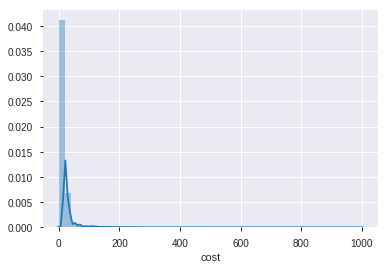

In [34]:
sns.distplot(y_train);

#### Terence Parr & Jeremy Howard, [The Mechanics of Machine Learning, Chapter 5.5](https://mlbook.explained.ai/prep.html#logtarget)

> Transforming the target variable (using the mathematical log function) into a tighter, more uniform space makes life easier for any model.

> The only problem is that, while easy to execute, understanding why taking the log of the target variable works and how it affects the training/testing process is intellectually challenging. You can skip this section for now, if you like, but just remember that this technique exists and check back here if needed in the future.

> Optimally, the distribution of prices would be a narrow “bell curve” distribution without a tail. This would make predictions based upon average prices more accurate. We need a mathematical operation that transforms the widely-distributed target prices into a new space. The “price in dollars space” has a long right tail because of outliers and we want to squeeze that space into a new space that is normally distributed (“bell curved”). More specifically, we need to shrink large values a lot and smaller values a little. That magic operation is called the logarithm or log for short. 

> To make actual predictions, we have to take the exp of model predictions to get prices in dollars instead of log dollars.

#### Wikipedia, [Logarithm](https://en.wikipedia.org/wiki/Logarithm)

> Addition, multiplication, and exponentiation are three fundamental arithmetic operations. Addition can be undone by subtraction. Multiplication can be undone by division. The idea and purpose of **logarithms** is also to **undo** a fundamental arithmetic operation, namely raising a number to a certain power, an operation also known as **exponentiation.** 

> For example, raising 2 to the third power yields 8.

> The logarithm (with respect to base 2) of 8 is 3, reflecting the fact that 2 was raised to the third power to get 8.

### Use Numpy for exponents and logarithms functions
- https://docs.scipy.org/doc/numpy/reference/routines.math.html#exponents-and-logarithms

In [35]:
print(np.e)
print(np.log(np.e))

2.718281828459045
1.0


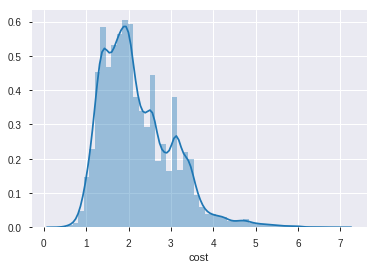

In [36]:
sns.distplot(np.log1p(y_train));

### Refit model with log-transformed target

In [37]:
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, np.log1p(y_train))
r2 = model.score(X_val, y_val)
print('Validation R^2:', r2)

y_pred = model.predict(X_val)
print(f'Validation RMSLE, Random Forest with {features}:')
print(rmsle(y_val, np.expm1(y_pred)))

Validation R^2: -0.11603519498399417
Validation RMSLE, Random Forest with ['quantity']:
0.622925465880199


### RMSLE with original targets = RMSE with log-transformed targets

In [0]:
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

In [39]:
rmse(np.log1p(y_val), y_pred)

0.622925465880199

## Interlude: Moore's Law dataset

#### Background
- https://en.wikipedia.org/wiki/Moore%27s_law
- https://en.wikipedia.org/wiki/Transistor_count

#### Scrape HTML tables with Pandas!
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_html.html
- https://medium.com/@ageitgey/quick-tip-the-easiest-way-to-grab-data-out-of-a-web-page-in-python-7153cecfca58

#### More web scraping options
- https://automatetheboringstuff.com/chapter11/

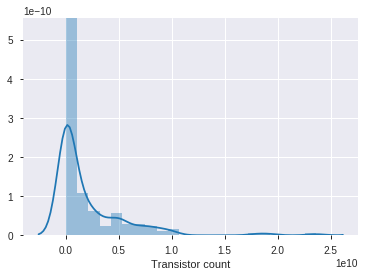

In [40]:
# Scrape data
tables = pd.read_html('https://en.wikipedia.org/wiki/Transistor_count', header=0)
moore = tables[0]
moore = moore[['Date of introduction', 'Transistor count']].dropna()

# Clean data
for column in moore:
    moore[column] = (moore[column]
                     .str.split('[').str[0]  # Remove citations
                     .str.replace(r'\D','')  # Remove non-digit characters
                     .astype(int))
    
moore = moore.sort_values(by='Date of introduction')

# Plot distribution of transistor counts
sns.distplot(moore['Transistor count']);

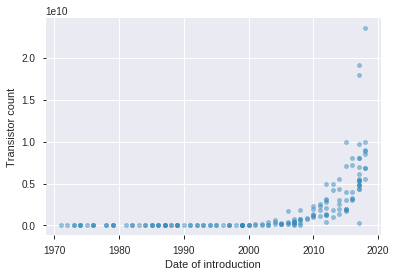

In [41]:
# Plot relationship between date & transistors
moore.plot(x='Date of introduction', y='Transistor count', kind='scatter', alpha=0.5);

In [0]:
# Log-transform the target
moore['log(Transistor count)'] = np.log1p(moore['Transistor count'])

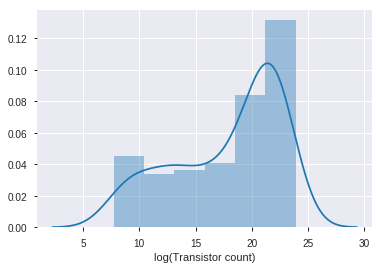

In [43]:
# Plot distribution of log-transformed target
sns.distplot(moore['log(Transistor count)']);

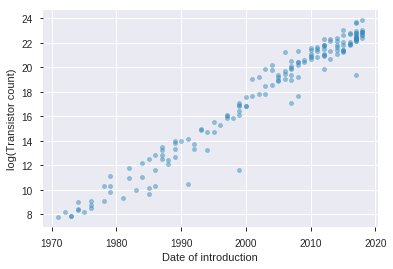

In [44]:
# Plot relationship between date & log-transformed target
moore.plot(x='Date of introduction', y='log(Transistor count)', kind='scatter', alpha=0.5);

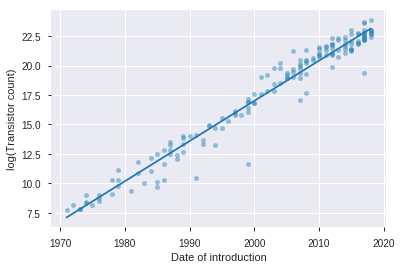

In [45]:
# Fit Linear Regression with log-transformed target
from sklearn.linear_model import LinearRegression
model = LinearRegression()
X = moore[['Date of introduction']]
y_log = moore['log(Transistor count)']
model.fit(X, y_log)
y_pred_log = model.predict(X)

# Plot line of best fit, in units of log-transistors
ax = moore.plot(x='Date of introduction', y='log(Transistor count)', kind='scatter', alpha=0.5)
ax.plot(X, y_pred_log);

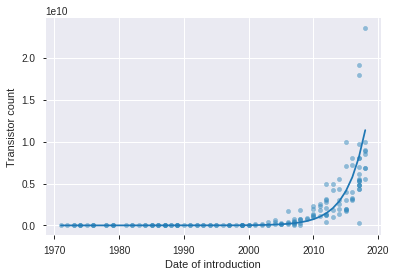

In [46]:
# Convert log-transistors to transistors
y_pred = np.expm1(y_pred_log)

# Plot line of best fit, in units of transistors
ax = moore.plot(x='Date of introduction', y='Transistor count', kind='scatter', alpha=0.5)
ax.plot(X, y_pred);

# Back to Caterpillar 🚜

### Select more features

#### [Data Description](https://www.kaggle.com/c/caterpillar-tube-pricing/data)

> **train_set.csv and test_set.csv**  
> This file contains information on price quotes from our suppliers. Prices can be quoted in 2 ways: bracket and non-bracket pricing. Bracket pricing has multiple levels of purchase based on quantity (in other words, the cost is given assuming a purchase of quantity tubes). Non-bracket pricing has a minimum order amount (min_order) for which the price would apply. Each quote is issued with an annual_usage, an estimate of how many tube assemblies will be purchased in a given year.

In [47]:
train.head(2)

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
8,TA-00004,S-0066,2013-07-07,0,0,Yes,1,21.972702
9,TA-00004,S-0066,2013-07-07,0,0,Yes,2,12.407983


In [48]:
train.describe()

,annual_usage,min_order_quantity,quantity,cost
count,22628.000000,22628.000000,22628.000000,22628.000000
mean,116.908830,2.130193,38.267677,13.450500
std,1678.532065,13.262875,71.313125,27.622252
min,0.000000,0.000000,1.000000,0.523027
25%,0.000000,0.000000,2.000000,3.855934
50%,0.000000,0.000000,10.000000,6.507236
75%,2.000000,0.000000,40.000000,13.451951
max,150000.000000,535.000000,2500.000000,1000.000000


In [49]:
train.select_dtypes(exclude=np.number).describe()

,tube_assembly_id,supplier,quote_date,bracket_pricing
count,22628,22628,22628,22628
unique,6641,52,1510,2
top,TA-04750,S-0066,2013-10-01,Yes
freq,12,15391,2077,19699


In [0]:
label = 'cost'
features = train.columns.to_list()
# features.remove(label)

# # remove some features
fs = [label,
      'tube_assembly_id', # Drop tube_assembly_id because our goal is to predict unknown assemblies
#       'supplier', 'quote_date',
#       'bracket_pricing',
     ]
for f in fs:
  features.remove(f)
  
X_train = train[features]
y_train = train[label]
X_val = val[features]
y_val = val[label]
X_test = test[features]
# y_test = test[label]

In [14]:
numeric_features = X_train[features].select_dtypes(include=np.number).columns.to_list()
categorical_features = train[features].select_dtypes(exclude=np.number).columns.to_list()
print((len(numeric_features), len(categorical_features)))

# select low cardinality features for one-hot encoding
# select high cardinality features for ordinal encoding
highcardi_features, lowcardi_features = [], []
for col in X_train[categorical_features]:
  if len(X_train[col].value_counts()) >= 10:
    highcardi_features.append(col)
  elif len(X_train[col].value_counts()) >= 2:
    lowcardi_features.append(col)
print((len(numeric_features), len(highcardi_features), len(lowcardi_features)))
print(numeric_features)
print(highcardi_features)
print(lowcardi_features)

(3, 3)
(3, 2, 1)
['annual_usage', 'min_order_quantity', 'quantity']
['supplier', 'quote_date']
['bracket_pricing']


In [0]:
###############################################
# Pipeline preprocessor
###############################################
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', ce.OneHotEncoder(drop_invariant=True, use_cat_names=True))]) 
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', ce.OrdinalEncoder())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('one', onehot_transformer, lowcardi_features), # categorical_features
        ('ord', ordinal_transformer, highcardi_features), # categorical_features
    ])
max_depth = 20

In [59]:
##############################################
# Choose a model
##############################################
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('pca', PCA(whiten=True)), # n_components=0.9, 
#                       ('svd', TruncatedSVD(n_components=200, random_state=5)), # 200059 cols
#                       ('lr', LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)),
#                       ('dt', DecisionTreeClassifier(max_depth=26)),
#                       ('et', ExtraTreesClassifier(max_depth=28)), # 0.788
#                       ('gb', GradientBoostingClassifier()), # 0.752
#                       ('gscv', GridSearchCV(boost, parameters)) # might take long time
                      ('rf', RandomForestRegressor(n_estimators=200, random_state=5, n_jobs=-1,
                                                    max_depth=max_depth, oob_score=True,
                                                   ))
                     ])
pipeline.fit(X_train, np.log1p(y_train))   
pred_val = pipeline.predict(X_val)
# print("R^2 score: %.3f" % pipeline['rf'].score(X_val, np.log1p(y_val)))
print("OOB score: %.3f" % pipeline['rf'].oob_score_)
print("RMSE score: %.3f" % rmse(np.log1p(y_val), pred_val))
print("RMSLE score: %.3f" % rmsle(y_val, np.expm1(pred_val)))

OOB score: 0.790
RMSE score: 0.409
RMSLE score: 0.409


#### Feature Importances

In [60]:
# Transformed features
tfs = pipeline['preprocessor'].named_transformers_
features_transformed = numeric_features + \
                       highcardi_features + \
                       tfs['one']['onehot'].get_feature_names()
print("numeric:", numeric_features)
print("ordinal:", highcardi_features)
print("onehot:", tfs['one']['onehot'].get_feature_names())

# Random forest feature importances
print(pipeline['rf'].n_features_, "feature importances:")
pd.DataFrame([features_transformed, pipeline['rf'].feature_importances_]).T.sort_values(1, ascending=False)

numeric: ['annual_usage', 'min_order_quantity', 'quantity']
ordinal: ['supplier', 'quote_date']
onehot: ['0_Yes', '0_No']
7 feature importances:


,0,1
2,quantity,0.526895
0,annual_usage,0.186562
6,0_No,0.139438
5,0_Yes,0.0963449
1,min_order_quantity,0.042829
3,supplier,0.00414021
4,quote_date,0.00379132


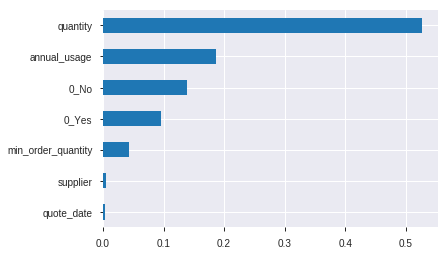

In [64]:
pd.Series(pipeline['rf'].feature_importances_, features_transformed).sort_values().plot.barh();

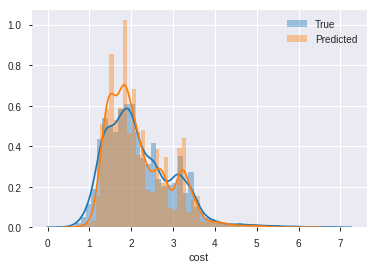

In [55]:
sns.distplot(np.log1p(y_val), label='True')
sns.distplot(pred_val, label='Predicted')
plt.legend();

In [56]:
###############################################
# Compare models
###############################################
regressors = [
    ('kn', KNeighborsRegressor(n_neighbors=3)),
#     ('svc', SVC(kernel="rbf", C=0.025, probability=True)),
#     ('nusvc', NuSVC(probability=True)),
#     ('lr', LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)),
    ('dt', DecisionTreeRegressor()),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=5, n_jobs=-1,
                                  max_depth=max_depth,)),    
    ('et', ExtraTreesRegressor(max_depth=28)),
    ('ada', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100)),
    ('gb', GradientBoostingRegressor()),
    ]

for regressor in regressors:
  pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              regressor,
                            ])      
  pipeline.fit(X_train, np.log1p(y_train))   
  pred_val = pipeline.predict(X_val)
  print(regressor)
  # print("R^2 score: %.3f" % pipeline['rf'].score(X_val, np.log1p(y_val)))
#   print("OOB score: %.3f" % pipeline['rf'].oob_score_)
  print("RMSE score: %.3f" % rmse(np.log1p(y_val), pred_val))
  print("RMSLE score: %.3f" % rmsle(y_val, np.expm1(pred_val)))
  print()

('kn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform'))
RMSE score: 0.556
RMSLE score: 0.556

('dt', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best'))
RMSE score: 0.488
RMSLE score: 0.488

('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
         

## Do feature engineering with relational data

#### [Data Description](https://www.kaggle.com/c/caterpillar-tube-pricing/data)

> The dataset is comprised of a large number of relational tables that describe the physical properties of tube assemblies. You are challenged to combine the characteristics of each tube assembly with supplier pricing dynamics in order to forecast a quote price for each tube.

> **tube.csv**  
> This file contains information on tube assemblies, which are the primary focus of the competition. Tube Assemblies are made of multiple parts. The main piece is the tube which has a specific diameter, wall thickness, length, number of bends and bend radius. Either end of the tube (End A or End X) typically has some form of end connection allowing the tube assembly to attach to other features. Special tooling is typically required for short end straight lengths (end_a_1x, end_a_2x refer to if the end length is less than 1 times or 2 times the tube diameter, respectively). Other components can be permanently attached to a tube such as bosses, brackets or other custom features.

In [57]:
for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)
    shared_columns = set(df.columns) & set(train.columns)
    if shared_columns:
        print(path, df.shape)
        print(df.columns.tolist(), '\n')

competition_data/test_set.csv (30235, 8)
['id', 'tube_assembly_id', 'supplier', 'quote_date', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity'] 

competition_data/train_set.csv (30213, 8)
['tube_assembly_id', 'supplier', 'quote_date', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity', 'cost'] 

competition_data/bill_of_materials.csv (21198, 17)
['tube_assembly_id', 'component_id_1', 'quantity_1', 'component_id_2', 'quantity_2', 'component_id_3', 'quantity_3', 'component_id_4', 'quantity_4', 'component_id_5', 'quantity_5', 'component_id_6', 'quantity_6', 'component_id_7', 'quantity_7', 'component_id_8', 'quantity_8'] 

competition_data/specs.csv (21198, 11)
['tube_assembly_id', 'spec1', 'spec2', 'spec3', 'spec4', 'spec5', 'spec6', 'spec7', 'spec8', 'spec9', 'spec10'] 

competition_data/tube.csv (21198, 16)
['tube_assembly_id', 'material_id', 'diameter', 'wall', 'length', 'num_bends', 'bend_radius', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'end

# Assignment
- Start a clean notebook.
- Get the [Caterpillar data from Kaggle](https://www.kaggle.com/c/caterpillar-tube-pricing/data).
- Do train/validate/test split.
- Select features from `train_set.csv`, `tube.csv`, and at least one more file.
- Fit a model.
- Get your validation RMSLE (or RMSE with log-transformed targets).
- [Submit](https://www.kaggle.com/c/caterpillar-tube-pricing/submit) your predictions to the Kaggle competition.
- Commit your notebook to your fork of the GitHub repo.

## Stretch Goals
- Improve your scores on Kaggle.
- Make visualizations and share on Slack.
- Look at [Kaggle Kernels](https://www.kaggle.com/c/caterpillar-tube-pricing/kernels) for ideas about feature engineerng and visualization.

Read [Better Explained](https://betterexplained.com/) Exponents & Logs series:

1. [An Intuitive Guide To Exponential Functions & e](https://betterexplained.com/articles/an-intuitive-guide-to-exponential-functions-e/)
2. [Demystifying the Natural Logarithm (ln)](https://betterexplained.com/articles/demystifying-the-natural-logarithm-ln/)
3. [A Visual Guide to Simple, Compound and Continuous Interest Rates](https://betterexplained.com/articles/a-visual-guide-to-simple-compound-and-continuous-interest-rates/)
4. [Common Definitions of e (Colorized)](https://betterexplained.com/articles/definitions-of-e-colorized/)
5. [Understanding Exponents (Why does 0^0 = 1?)](https://betterexplained.com/articles/understanding-exponents-why-does-00-1/)
6. [Using Logarithms in the Real World](https://betterexplained.com/articles/using-logs-in-the-real-world/)
7. [How To Think With Exponents And Logarithms](https://betterexplained.com/articles/think-with-exponents/)
8. [Understanding Discrete vs. Continuous Growth](https://betterexplained.com/articles/understanding-discrete-vs-continuous-growth/)
9. [What does an exponent really mean?](https://betterexplained.com/articles/what-does-an-exponent-mean/)
10. [Q: Why is e special? (2.718..., not 2, 3.7 or another number?)](https://betterexplained.com/articles/q-why-is-e-special-2-718-not-other-number/)

<img src="https://github.com/Nov05/DS-Unit-2-Applied-Modeling/blob/master/images/CAT_ER.png?raw=true">  

## XGBoost

In [73]:
%%time
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('xgb', XGBRegressor(n_estimators=1000, n_jobs=-1)),
                     ])
pipeline.fit(X_train, np.log1p(y_train))   
pred_val = pipeline.predict(X_val)
print('Validation Error', rmse(np.log1p(y_val), pred_val))

[00:53:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation Error 0.4289236121321444
CPU times: user 13.4 s, sys: 21.4 ms, total: 13.4 s
Wall time: 6.83 s


### Early Stopping in XGBoost

In [0]:
%%time

# eval data should be preprocessed
eval_set = []

# Early stopping
class XGBRegressorEval(XGBRegressor):
  def fit(self, *args, **kwargs):
    return super().fit(*args, 
                       eval_set=eval_set, # here needs a fix
                       eval_metric='rmse', 
                       early_stopping_rounds=100, 
                       **kwargs)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('xgb', XGBRegressorEval(n_estimators=1000, n_jobs=-1)),
                     ])
eval_set = [(pipeline['preprocessor'].fit_transform(X_train), np.log1p(y_train)),
            (pipeline['preprocessor'].fit_transform(X_val), np.log1p(y_val)),
           ]
pipeline.fit(X_train, np.log1p(y_train))   
pred_val = pipeline.predict(X_val)  

print('Validation Error', rmse(np.log1p(y_val), pred_val))

"""
[133]	validation_0-rmse:0.421376	validation_1-rmse:0.595385
Stopping. Best iteration:
[33]	validation_0-rmse:0.483706	validation_1-rmse:0.579654

Validation Error 0.492939812246325
CPU times: user 3.54 s, sys: 63.1 ms, total: 3.6 s
Wall time: 2.29 s
"""

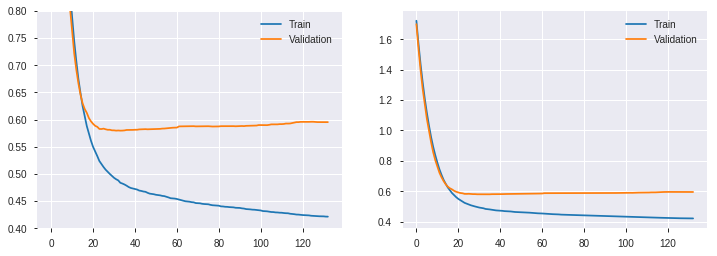

In [87]:
rmse_train = pipeline['xgb'].evals_result()['validation_0']['rmse']
rmse_val = pipeline['xgb'].evals_result()['validation_1']['rmse']
epoch = range(len(rmse_train))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epoch, rmse_train, label='Train')
plt.plot(epoch, rmse_val, label='Validation')
plt.ylim((0.4, 0.8))
plt.legend();
plt.subplot(1,2,2)
plt.plot(epoch, rmse_train, label='Train')
plt.plot(epoch, rmse_val, label='Validation')
plt.legend();

### Cross-validation

In [27]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('rf', RandomForestRegressor(n_estimators=100, random_state=5, n_jobs=-1,
#                                                         max_depth=max_depth, 
                                                        oob_score=True,)),
                          ])
k = 3
groups = train['tube_assembly_id']
scores = cross_val_score(pipeline, X_train, np.log1p(y_train), cv=k, 
                         scoring='neg_mean_squared_error', groups=groups)
print(f'RMSLE for {k} folds:', np.sqrt(-scores))

RMSLE for 3 folds: [0.42908952 0.46085536 0.51136441]


In [29]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'rf', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__one', 'preprocessor__ord', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__one__memory', 'preprocessor__one__steps', 'preprocessor__one__verbose', 'preprocessor__one__imputer', 'preprocessor__one__onehot', 'preprocessor__one__imputer__add_indicator'

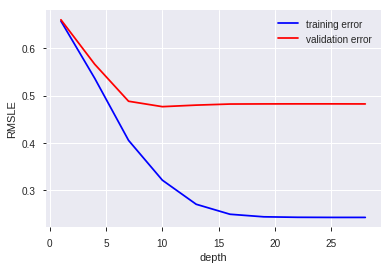

In [32]:
depth = range(1, 31, 3)
train_scores, val_scores = validation_curve(
    pipeline, X_train, np.log1p(y_train),
    param_name='rf__max_depth', 
    param_range=depth, 
    scoring='neg_mean_squared_error', 
    cv=2, 
    groups=groups)

rmsle_train = np.sqrt(-train_scores)
rmsle_val = np.sqrt(-val_scores)
plt.plot(depth, np.mean(rmsle_train, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(rmsle_val, axis=1), color='red', label='validation error')
plt.xlabel('depth')
plt.ylabel('RMSLE')
plt.legend();

### XGboost cross-validation

In [41]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('xgb', XGBRegressor(random_state=5)),
                          ])
param_distributions = {
    'xgb__n_estimators': (100, 1500), 
    'xgb__max_depth': (1, 30)
}
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_squared_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)
groups = train['tube_assembly_id']
search.fit(X_train, np.log1p(y_train), groups=groups)   

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:   12.1s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   24.9s finished
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   24.9s remaining:    0.0s


[06:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                     

In [31]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'xgb', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__one', 'preprocessor__ord', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__one__memory', 'preprocessor__one__steps', 'preprocessor__one__verbose', 'preprocessor__one__imputer', 'preprocessor__one__onehot', 'preprocessor__one__imputer__add_indicator

In [42]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

Best hyperparameters {'xgb__n_estimators': 100, 'xgb__max_depth': 30}
Cross-validation RMSLE 0.511098518427849


In [43]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__n_estimators,param_xgb__max_depth,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
2,5.188811,0.147231,0.341331,0.012991,100,30,"{'xgb__n_estimators': 100, 'xgb__max_depth': 30}",-0.215538,-0.306905,-0.261222,0.045684,1,-0.054733,-0.039324,-0.047029,0.007704
3,11.423413,0.278228,0.729873,0.021187,1500,30,"{'xgb__n_estimators': 1500, 'xgb__max_depth': 30}",-0.215767,-0.306923,-0.261345,0.045578,2,-0.054727,-0.039319,-0.047023,0.007704
1,4.853922,0.015401,0.300738,0.009759,1500,1,"{'xgb__n_estimators': 1500, 'xgb__max_depth': 1}",-0.246497,-0.368107,-0.307302,0.060805,3,-0.266883,-0.190402,-0.228642,0.038241
0,0.375443,0.003559,0.041012,0.002085,100,1,"{'xgb__n_estimators': 100, 'xgb__max_depth': 1}",-0.283093,-0.429521,-0.356307,0.073214,4,-0.404681,-0.265734,-0.335208,0.069474


## Drop-column Importance

In [0]:
%%time
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('xgb', XGBRegressor(n_estimators=100, n_jobs=-1)),
                     ])
cols_drop = ['supplier']
  
# Fit with column
pipeline.fit(X_train, np.log1p(y_train))   
pred_val = pipeline.predict(X_val)
score_with = rmse(np.log1p(y_val), pred_val)
print(f'Validation Error with {cols_drop}', score_with)

# Fit without column
# ValueError: 'quantity' is not in list
pipeline.fit(X_train.drop(columns=cols_drop), np.log1p(y_train))   
pred_val = pipeline.predict(X_val.drop(columns=col_drop))
score_without = rmse(np.log1p(y_val), pred_val)
print(f'Validation Error without {cols_drop}', score_without)

# Compare the error with & without column
print(f'Drop-Column Importance for {col_drop}:', score_without - score_with)

### Permutation Importance

In [48]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('xgb', XGBRegressor(n_estimators=100, n_jobs=-1)),
                     ])
feature = 'quantity'

def permutation_importance(feature='quantity'):
  X_val_permuted = X_val.copy()
  X_val_permuted[feature] = np.random.permutation(X_val_permuted[feature])

  # Fit with column
  pipeline.fit(X_train, np.log1p(y_train))   
  pred_val = pipeline.predict(X_val)
  score_with = rmse(np.log1p(y_val), pred_val)
  print(f'Validation Error with {cols_drop}', score_with)

  # Predict with permutated column
  pred_val = pipeline.predict(X_val_permuted)
  score_permuted = rmse(np.log1p(y_val), pred_val)
  print(f'Validation Error with {cols_drop}', score_permuted)

  print(f'Validation RMSLE with {feature}:', score_with)
  print(f'Validation RMSLE with {feature} permuted:', score_permuted)
  print(f'Permutation Importance:', score_permuted - score_with)
  
permutation_importance()

[06:40:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation Error with ['supplier'] 0.45619847505202205
Validation Error with ['supplier'] 0.9679079478082928
Validation RMSLE with quantity: 0.45619847505202205
Validation RMSLE with quantity permuted: 0.9679079478082928
Permutation Importance: 0.5117094727562708


In [49]:
permutation_importance('supplier')

[06:40:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation Error with ['supplier'] 0.45619847505202205
Validation Error with ['supplier'] 0.5859841139653882
Validation RMSLE with supplier: 0.45619847505202205
Validation RMSLE with supplier permuted: 0.5859841139653882
Permutation Importance: 0.12978563891336614


### eli5 library feature importance

https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance  



In [84]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('xgb', XGBRegressor(n_estimators=100, n_jobs=-1)),
                     ])
pipeline.fit(X_train, np.log1p(y_train))

permuter = PermutationImportance(pipeline['xgb'], 
                                 scoring='neg_mean_squared_error', 
                                 cv='prefit', 
                                 n_iter=2, 
                                 random_state=5)
permuter.fit(pipeline['preprocessor'].transform(X_val), np.log1p(y_val))

# Transformed features
tfs = pipeline['preprocessor'].named_transformers_
features_transformed = numeric_features + \
                       highcardi_features + \
                       tfs['one']['onehot'].get_feature_names()

eli5.show_weights(permuter, top=None, feature_names=features_transformed)

[07:14:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Weight,Feature
0.7420 ± 0.0006,quantity
0.1342 ± 0.0063,0_Yes
0.1308 ± 0.0008,min_order_quantity
0.1211 ± 0.0022,annual_usage
0.0437 ± 0.0018,0_No
0.0005 ± 0.0001,supplier
0 ± 0.0000,quote_date


### Partial Dependence

In [0]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('xgb', XGBRegressor(n_estimators=100, n_jobs=-1)),
                          ])
pipeline.fit(X_train, np.log1p(y_train))

# Transformed features
tfs = pipeline['preprocessor'].named_transformers_
features_transformed = numeric_features + \
                       highcardi_features + \
                       tfs['one']['onehot'].get_feature_names()

feature = 'quatity'
dataset = pd.DataFrame(pipeline['preprocessor'].transform(X_val))
dataset.columns = features_transformed 

# ValueError: feature_names mismatch
isolated = pdp_isolate(
    model=pipeline['xgb'], 
    dataset=dataset, 
    model_features=features_transformed, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

In [108]:
print(X_val.shape)
print(X_val.columns.to_list())
pd.DataFrame(pipeline['preprocessor'].transform(X_val)).head(2)

(7585, 6)
['supplier', 'quote_date', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity']


,0,1,2,3,4,5,6
0,-0.069651,-0.160617,-0.522604,1.0,0.0,1.0,1.0
1,-0.069651,-0.160617,-0.508581,1.0,0.0,1.0,1.0
